# Cats and Dogs Object Detector (CaDoD) -- Group 24 -- Phase 1
Classification of Cats vs. Dogs in Images and Determination of Bounding Boxes for Object of Interest

## Team Members
- David Rivera Pinhao [driverap@iu.edu]
- Chinmay Kunte [cvkunte@iu.edu]
- Atharva Kulkarni [athakulk@iu.edu]
- Sanket Atmaram Darwante [sdarwant@iu.edu]

## Project Abstract
Computer vision is a field of study that deals with how computers can gain the ability to “see”. One of the biggest challenges is object detection. In this phase, we will explore the Cats and Dogs dataset and build a baseline model that will be able to classify the images. We used Logistic Regression as our classifier which was optimized using stochastic gradient descent and an adaptive learning rate. Finally, we used Linear Regression to predict bounding boxes and again used gradient descent. This was implemented using SKLearn’s build in models SGDClassifier and LinearRegression. From about 12k images we achieved a test accuracy of 0.554 with a mean squared error of 0.035 for classifying images and predicting the bounding boxes, respectively. Overall, this proved to be a good baseline and benchmark. We plan to take this further in our next experiments to improve both metrics using Deep Learning.

[change for Phase 1]

## Project Description
The purpose of this project is create an end to end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

[change for Phase 1]

## Data Description
The image archive `cadod.tar.gz` is a subset of Open Images V6. It contains a total of 12,966 images of dogs and cats.

Image bounding boxes are stored in the csv file `cadod.csv`. This .csv files consists of the following columns.
- ImageID: the image this box lives in.
- Source: indicates how the box was made:
    - xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    - activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
- LabelName: the MID of the object class this box belongs to.
- Confidence: a dummy value, always 1.
- XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
- XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:
- IsOccluded: Indicates that the object is occluded by another object in the image.
- IsTruncated: Indicates that the object extends beyond the boundary of the image.
- IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 - instances which are heavily occluding each other and are physically touching.
- IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
- IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building). For each of them, value 1 indicates present, 0 not present, and -1 unknown.

# Import Data

First we import all of the necessary python packages at once.

In [1]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tarfile
from tqdm.notebook import tqdm
import warnings
import seaborn as sns
%matplotlib inline

## Unarchive Data

The images are, at first, stored in the `cadod.tar.gz` file. The following function extracts the files to the specified path.

In [2]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [3]:
path = 'data/'
extract_tar('cadod.tar.gz', path)

  0%|          | 0/25936 [00:00<?, ?it/s]

Files already exist


## Load Bounding Box Metadata

The bounding box metadata is stored in the `cadod.csv` file, which is read into a Pandas Dataframe that allows us to perform exploratory data analysis below.

In [4]:
df = pd.read_csv('cadod.csv')

In [5]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Exploratory Data Analysis

## Statistics

Check and make sure that there are 12,966 images in the data directory and check the size of the data directory in MB.

In [6]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")
print(f"The total size is {os.path.getsize(path)/1000} MB")

There are a total of 12966 images
The total size is 830.048 MB


The dataframe should have 12,966 rows and 21 columns.

In [7]:
df.shape

(12966, 21)

Check and make sure there are no empty or NaN cells in the dataframe.

In [8]:
df.isnull().values.any()

False

Let's summarize the dataframe using `.info()` and `.describe(include = 'all')`. The `include = 'all'` forces the output to include the non-numerical features.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12966 entries, 0 to 12965
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      12966 non-null  object 
 1   Source       12966 non-null  object 
 2   LabelName    12966 non-null  object 
 3   Confidence   12966 non-null  int64  
 4   XMin         12966 non-null  float64
 5   XMax         12966 non-null  float64
 6   YMin         12966 non-null  float64
 7   YMax         12966 non-null  float64
 8   IsOccluded   12966 non-null  int64  
 9   IsTruncated  12966 non-null  int64  
 10  IsGroupOf    12966 non-null  int64  
 11  IsDepiction  12966 non-null  int64  
 12  IsInside     12966 non-null  int64  
 13  XClick1X     12966 non-null  float64
 14  XClick2X     12966 non-null  float64
 15  XClick3X     12966 non-null  float64
 16  XClick4X     12966 non-null  float64
 17  XClick1Y     12966 non-null  float64
 18  XClick2Y     12966 non-null  float64
 19  XCli

In [10]:
df.describe(include = 'all')

ImageID  Source  LabelName  Confidence          XMin  \
count              12966   12966      12966     12966.0  12966.000000   
unique             12966       2          2         NaN           NaN   
top     0000b9fcba019d36  xclick  /m/0bt9lr         NaN           NaN   
freq                   1   12542       6855         NaN           NaN   
mean                 NaN     NaN        NaN         1.0      0.099437   
std                  NaN     NaN        NaN         0.0      0.113023   
min                  NaN     NaN        NaN         1.0      0.000000   
25%                  NaN     NaN        NaN         1.0      0.000000   
50%                  NaN     NaN        NaN         1.0      0.061250   
75%                  NaN     NaN        NaN         1.0      0.167500   
max                  NaN     NaN        NaN         1.0      0.592500   

                XMax          YMin          YMax    IsOccluded   IsTruncated  \
count   12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.901750      0.088877      0.945022      0.464754      0.738470   
std         0.111468      0.097345      0.081500      0.499239      0.440011   
min         0.408125      0.000000      0.451389     -1.000000     -1.000000   
25%         0.830625      0.000000      0.910000      0.000000      0.000000   
50%         0.941682      0.059695      0.996875      0.000000      1.000000   
75%         0.998889      0.144853      0.999062      1.000000      1.000000   
max         1.000000      0.587088      1.000000      1.000000      1.000000   

        ...   IsDepiction      IsInside      XClick1X      XClick2X  \
count   ...  12966.000000  12966.000000  12966.000000  12966.000000   
unique  ...           NaN           NaN           NaN           NaN   
top     ...           NaN           NaN           NaN           NaN   
freq    ...           NaN           NaN           NaN           NaN   
mean    ...      0.045427      0.001157      0.390356      0.424582   
std     ...      0.209354      0.040229      0.358313      0.441751   
min     ...     -1.000000     -1.000000     -1.000000     -1.000000   
25%     ...      0.000000      0.000000      0.221293      0.096875   
50%     ...      0.000000      0.000000      0.435625      0.415625   
75%     ...      0.000000      0.000000      0.609995      0.820000   
max     ...      1.000000      1.000000      0.999375      0.999375   

            XClick3X      XClick4X      XClick1Y      XClick2Y      XClick3Y  \
count   12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.494143      0.506689      0.275434      0.447448      0.641749   
std         0.405033      0.462281      0.415511      0.401580      0.448054   
min        -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%         0.285071      0.130000      0.024323      0.218333      0.405816   
50%         0.531919      0.623437      0.146319      0.480838      0.825000   
75%         0.787500      0.917529      0.561323      0.729069      0.998042   
max         1.000000      0.999375      0.999375      0.999375      1.000000   

            XClick4Y  
count   12966.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        0.582910  
std         0.403454  
min        -1.000000  
25%         0.400000  
50%         0.646667  
75%         0.882500  
max         0.999375  

[11 rows x 21 columns]

Determine which of the columns are numerical and which are categorical. The columns that are integers are actually categorical features and have just been encoded to numbers. This was easily discerned and checked by looking at the dataframes above.

In [11]:
numerical_ix = df.select_dtypes(include = ['float64']).columns
categorical_ix = df.select_dtypes(include = ['object', 'bool', 'int64']).columns
print(f'numerical   features: {list(numerical_ix)}')
print(f'categorical features: {list(categorical_ix)}')

numerical   features: ['XMin', 'XMax', 'YMin', 'YMax', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y', 'XClick2Y', 'XClick3Y', 'XClick4Y']
categorical features: ['ImageID', 'Source', 'LabelName', 'Confidence', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside']


Let's replace the `LabelName` column so that is has human-readable labels.

In [12]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace = True)
df.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick       dog           1  0.165000  0.903750   
1  0000cb13febe0138  xclick       dog           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick       dog           1  0.094167  0.611667   
3  0006303f02219b07  xclick       dog           1  0.000000  0.999219   
4  00064d23bf997652  xclick       dog           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

In [13]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

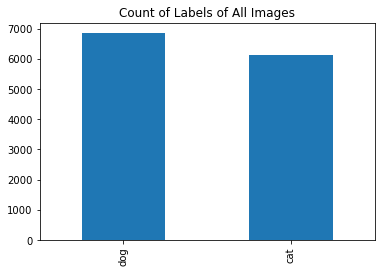

In [14]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Count of Labels of All Images')
plt.show()

The data consists of about ~12% more dog images than cat images.

Let's check the value counts of a few more categorical features.

In [15]:
df[['LabelName', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside']].apply(pd.Series.value_counts)

LabelName  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  IsInside
-1         NaN         3.0          3.0        3.0          3.0       3.0
0          NaN      6934.0       3385.0    12783.0      12371.0   12945.0
1          NaN      6029.0       9578.0      180.0        592.0      18.0
cat     6111.0         NaN          NaN        NaN          NaN       NaN
dog     6855.0         NaN          NaN        NaN          NaN       NaN

Let's check the correlation between all of the features in the dataframe.

In [16]:
df.corr()

Confidence      XMin      XMax      YMin      YMax  IsOccluded  \
Confidence          NaN       NaN       NaN       NaN       NaN         NaN   
XMin                NaN  1.000000  0.103804  0.090813  0.006290    0.112251   
XMax                NaN  0.103804  1.000000 -0.083529  0.001176   -0.115249   
YMin                NaN  0.090813 -0.083529  1.000000 -0.073181    0.147739   
YMax                NaN  0.006290  0.001176 -0.073181  1.000000   -0.062223   
IsOccluded          NaN  0.112251 -0.115249  0.147739 -0.062223    1.000000   
IsTruncated         NaN -0.149003  0.157319 -0.208849  0.343788   -0.093756   
IsGroupOf           NaN -0.045129  0.047915 -0.007378 -0.010383    0.089984   
IsDepiction         NaN -0.003565 -0.020573  0.015071 -0.035134   -0.032279   
IsInside            NaN -0.001281  0.001948  0.005109 -0.023480    0.026993   
XClick1X            NaN  0.171845  0.082206  0.047808 -0.006224    0.073061   
XClick2X            NaN  0.104226  0.110433  0.008927 -0.006295    0.029136   
XClick3X            NaN  0.154513  0.234758 -0.001801 -0.009941    0.042914   
XClick4X            NaN  0.184075  0.176847  0.037606  0.008905    0.100454   
XClick1Y            NaN -0.014338 -0.012135  0.135875  0.018956    0.080188   
XClick2Y            NaN  0.001371 -0.036563  0.176044  0.091570    0.091800   
XClick3Y            NaN  0.037439  0.038044  0.101187  0.145309    0.035143   
XClick4Y            NaN  0.014788  0.051177  0.098794  0.131983    0.066217   

             IsTruncated  IsGroupOf  IsDepiction  IsInside  XClick1X  \
Confidence           NaN        NaN          NaN       NaN       NaN   
XMin           -0.149003  -0.045129    -0.003565 -0.001281  0.171845   
XMax            0.157319   0.047915    -0.020573  0.001948  0.082206   
YMin           -0.208849  -0.007378     0.015071  0.005109  0.047808   
YMax            0.343788  -0.010383    -0.035134 -0.023480 -0.006224   
IsOccluded     -0.093756   0.089984    -0.032279  0.026993  0.073061   
IsTruncated     1.000000  -0.017391    -0.095418 -0.004693  0.009881   
IsGroupOf      -0.017391   1.000000     0.031091  0.045410  0.040796   
IsDepiction    -0.095418   0.031091     1.000000  0.021234  0.014577   
IsInside       -0.004693   0.045410     0.021234  1.000000  0.026219   
XClick1X        0.009881   0.040796     0.014577  0.026219  1.000000   
XClick2X        0.032514   0.025022    -0.002304  0.031492  0.515711   
XClick3X        0.057065   0.016812    -0.013640  0.016644  0.302655   
XClick4X        0.014494   0.012422     0.002735 -0.001875  0.351178   
XClick1Y        0.003144  -0.010900    -0.001785  0.024680  0.292254   
XClick2Y        0.019021   0.022449     0.011127  0.005625  0.514306   
XClick3Y        0.081859   0.032975     0.007438  0.014154  0.558042   
XClick4Y        0.090464   0.016375    -0.001444  0.005826  0.490527   

             XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
Confidence        NaN       NaN       NaN       NaN       NaN       NaN   
XMin         0.104226  0.154513  0.184075 -0.014338  0.001371  0.037439   
XMax         0.110433  0.234758  0.176847 -0.012135 -0.036563  0.038044   
YMin         0.008927 -0.001801  0.037606  0.135875  0.176044  0.101187   
YMax        -0.006295 -0.009941  0.008905  0.018956  0.091570  0.145309   
IsOccluded   0.029136  0.042914  0.100454  0.080188  0.091800  0.035143   
IsTruncated  0.032514  0.057065  0.014494  0.003144  0.019021  0.081859   
IsGroupOf    0.025022  0.016812  0.012422 -0.010900  0.022449  0.032975   
IsDepiction -0.002304 -0.013640  0.002735 -0.001785  0.011127  0.007438   
IsInside     0.031492  0.016644 -0.001875  0.024680  0.005625  0.014154   
XClick1X     0.515711  0.302655  0.351178  0.292254  0.514306  0.558042   
XClick2X     1.000000  0.349234 -0.111941  0.339360  0.379019  0.396836   
XClick3X     0.349234  1.000000  0.460921  0.443243  0.360727  0.445288   
XClick4X    -0.111941  0.460921  1.000000  0.341789  0.412812  0.397735   
XClick1Y     0.33

[INSERT ANALYSIS OF CORRELATION HERE]

Let's visualize the correlation of a few select features.

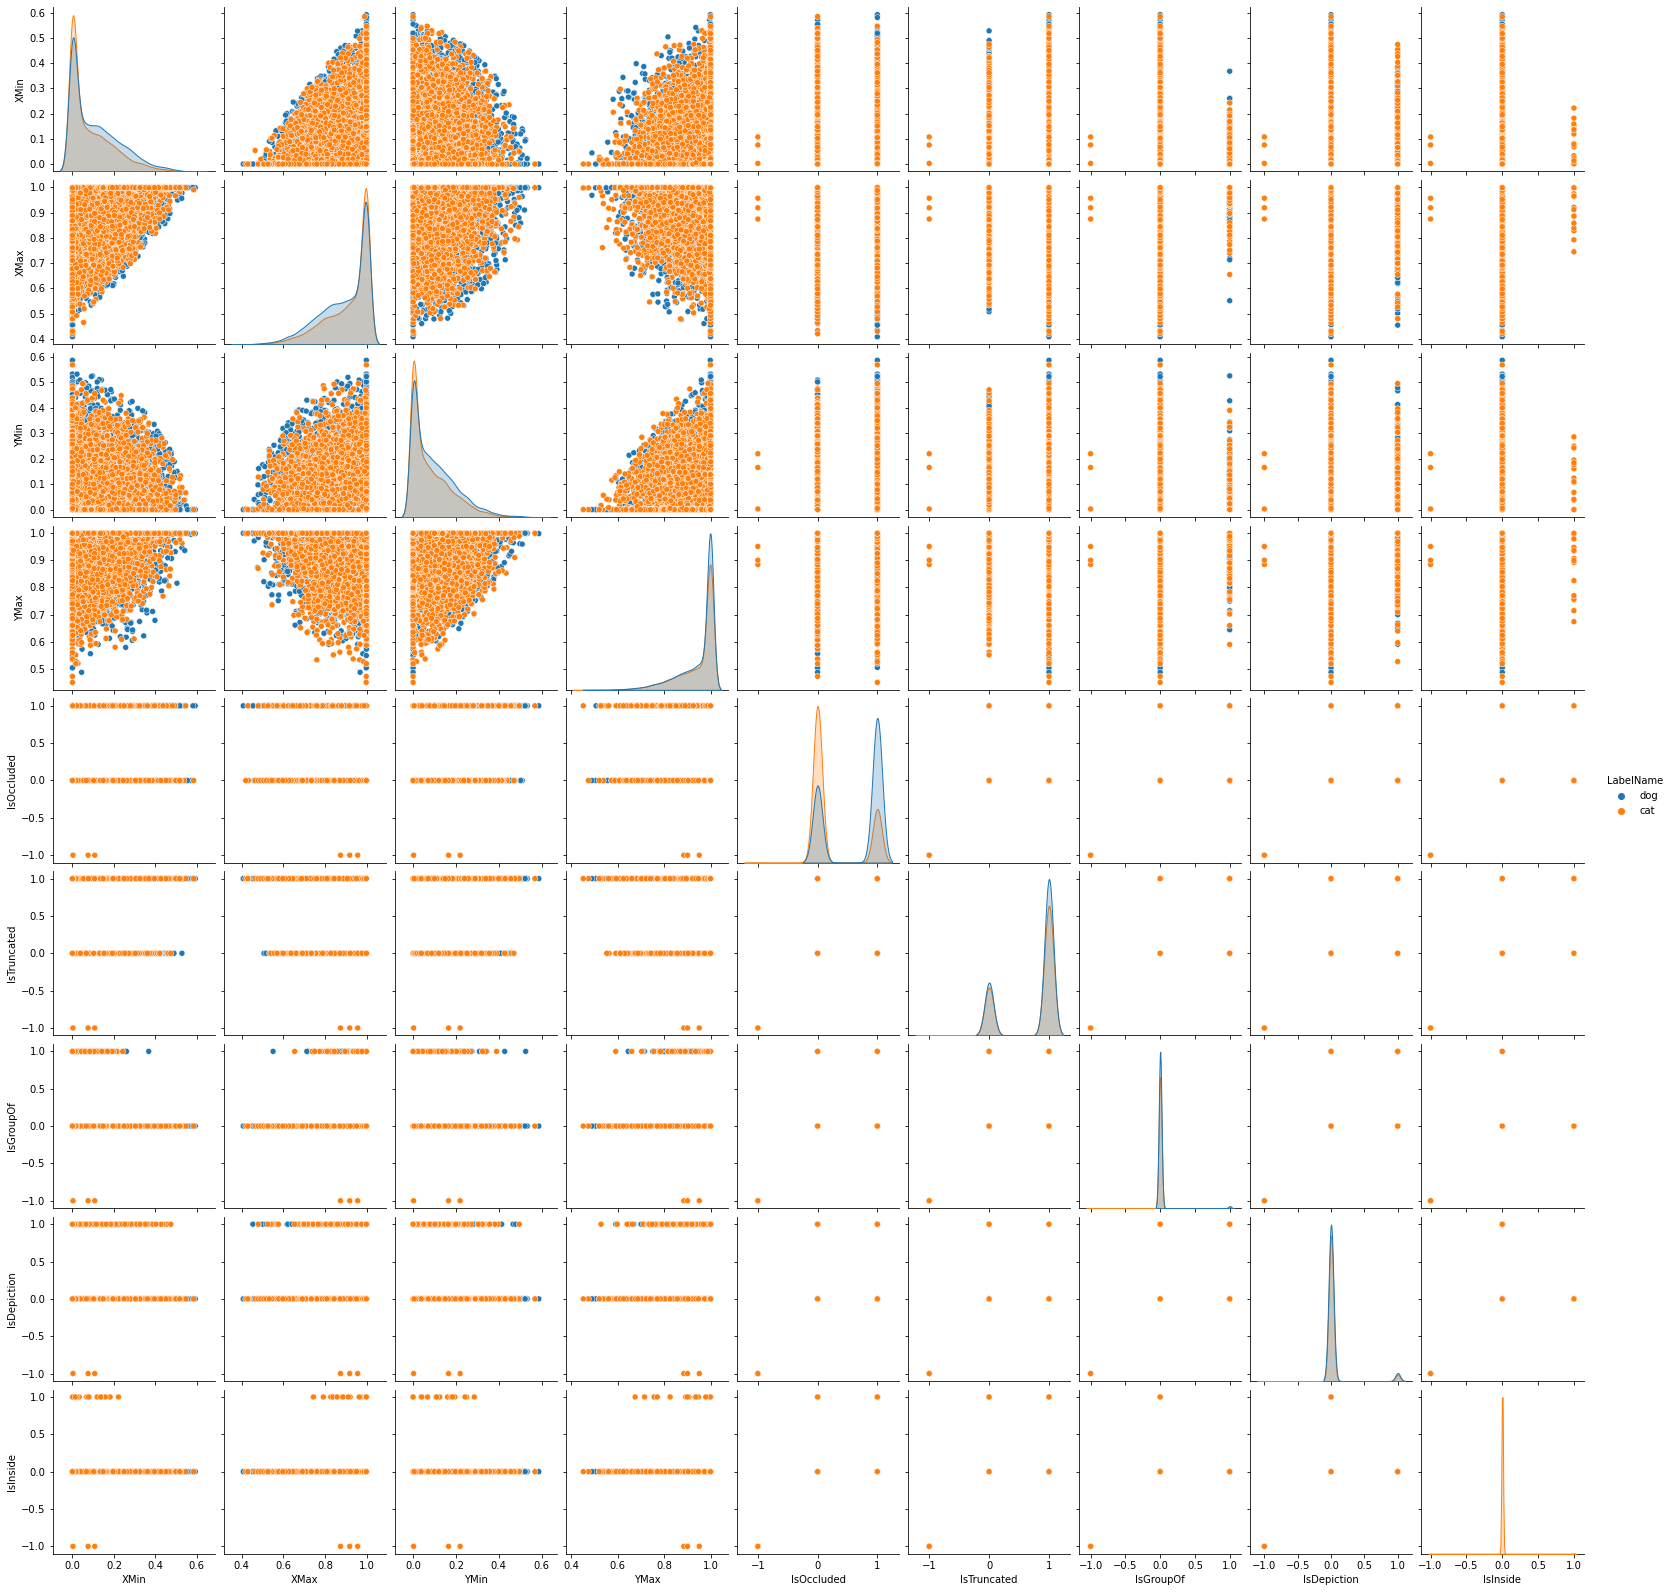

In [17]:
sns.pairplot(data = df, hue = 'LabelName', vars = ['XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside'])

[INSERT ANALYSIS OF VISUAL CORRELATION HERE]

## Image Samples

The code below outputs six random images from the data directory. The code also adds the bounding box information for the six images which are extracted from the dataframe of the `cadod.csv` file.

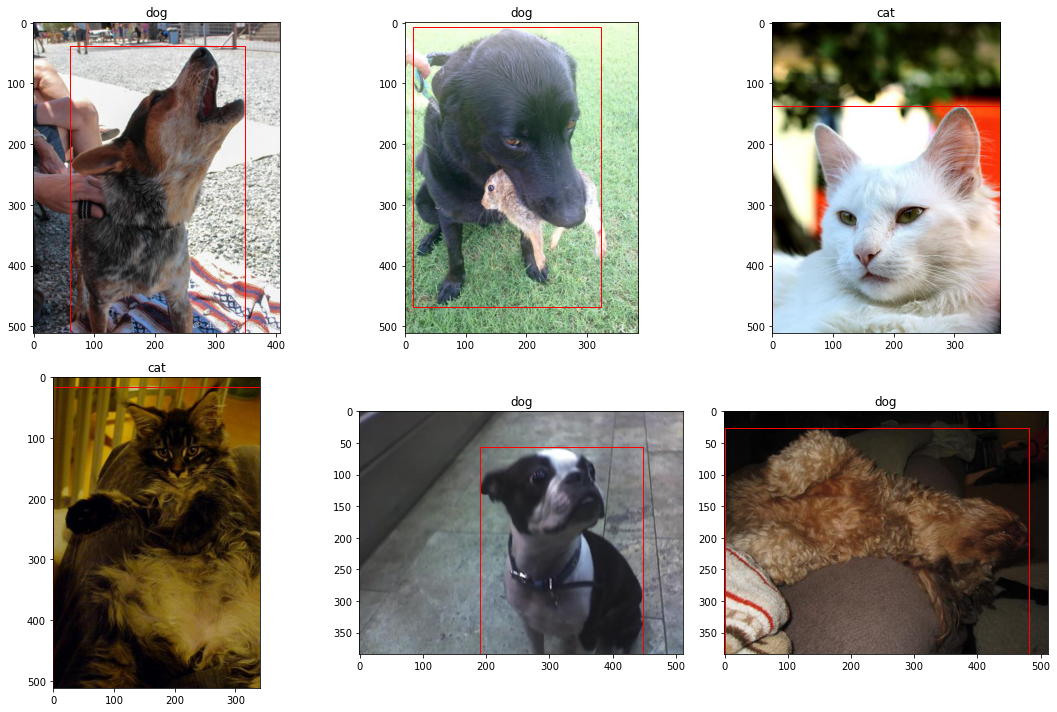

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(df.shape[0], size = 6, replace = False)):
    img = mpimg.imread('data/' + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j, 4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    ax[i].add_patch(plt.Rectangle((coords[0] * w, coords[2] * h),
                                  coords[1] * w - coords[0] * w, coords[3] * h - coords[2] * h,
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

## Image Shapes and Sizes

It is evident from the sample images above that there is a wide variety of image sizes and shapes. Let's go through all of the images in the data directory and store the shape and size information in a numpy array.

In [19]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))

for i, f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path + '/' + f
    img = Image.open(file)
    img_shape.append(f'{img.size[0]}x{img.size[1]}')
    img_size[i] += os.path.getsize(file)

  0%|          | 0/12966 [00:00<?, ?it/s]

We can count the different shape sizes using a `Counter` object and a Pandas dataframe.

In [21]:
img_shape_count = Counter(img_shape)

In [22]:
img_df = pd.DataFrame(set(img_shape_count.items()), columns = ['img_shape', 'img_count'])
img_df

img_shape  img_count
0     400x512          4
1     353x512          5
2     451x512          3
3     460x512          5
4     406x512          5
..        ...        ...
589   512x404         11
590   300x512          1
591   512x472          8
592   512x483          7
593   277x512          1

[594 rows x 2 columns]

In [23]:
img_df.shape

(594, 2)

There are a ton of different image shapes: 594, to be exact. Let's narrow this down by getting a sum of any image shape that has a count less than 100 and put that in a category called `other`.

In [24]:
img_df = img_df.append({'img_shape': 'other', 'img_count': img_df[img_df.img_count < 100].img_count.sum()},
                       ignore_index = True)
img_df

img_shape  img_count
0     400x512          4
1     353x512          5
2     451x512          3
3     460x512          5
4     406x512          5
..        ...        ...
590   300x512          1
591   512x472          8
592   512x483          7
593   277x512          1
594     other       3259

[595 rows x 2 columns]

We can now drop any rows where the `img_count` is less than 100.

In [25]:
img_df = img_df[img_df.img_count >= 100]
img_df

img_shape  img_count
96    512x382        127
157   512x512       1103
218   512x288        182
300   512x342        392
315   384x384        113
357   512x340        736
368   384x512        616
411   340x512        143
456   341x512        331
466   512x341       2013
521   512x339        169
530   512x384       3782
594     other       3259

The below code verifies that we did not remove any images in the count.

In [26]:
img_df.img_count.sum() == df.shape[0]

True

We can now plot the counts of the image shapes.

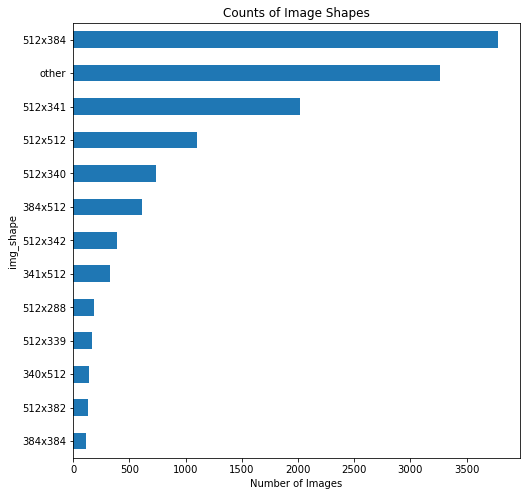

In [28]:
img_df.sort_values('img_count', inplace = True)
img_df.plot(x = 'img_shape', y = 'img_count', kind = 'barh', figsize = (8,8), legend = False)
plt.title('Counts of Image Shapes')
plt.xlabel('Number of Images')
plt.show()

The `other` image shape encompasses a large number of images, which indicates that the image shapes are extremely varied. This is a problem for when we want to use machine learning as we want each image sample to have the same number of features.

Now we can take a look at the image sizes. The code below plots the distribution of the image sizes in MB.

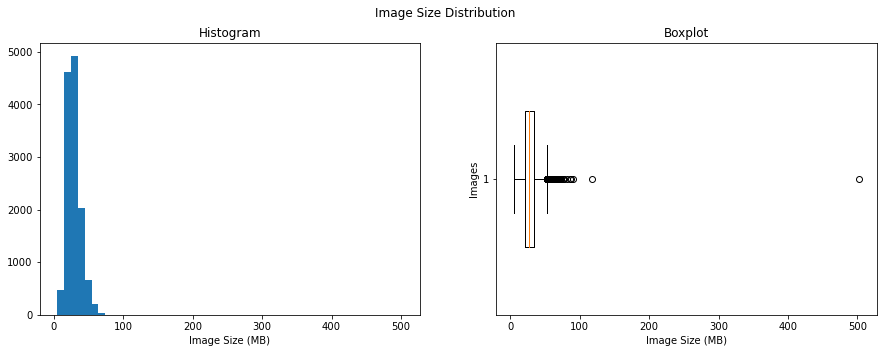

In [29]:
img_size = img_size / 1000

fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

Most of the images appear to be between 0 and 100 MB in size, though the boxplot clearly indicates that there are some outliers in the distribution, including what appears to be one image that is substantially larger than the others at about 500 MB.

[ADD MORE EXPLORATORY DATA ANALYSIS IF NECESSARY]

# Preprocessing

The exploratory data analysis revealed that the images have many different shapes and sizes. In order for the images to be used to create machine learning models, the images need to be consistently shaped so that each image sample has the same number of features. Therefore, the first step before creating the models is to preprocess the data by rescaling each image to a specific size. Here, we choose image sizes of 128 x 128 pixels, so that each image is a square. This will also reduce the size of most of the images so that the machine learning algorithms can run faster on them while preserving the appearence of the images. The resized images are placed in the `data/resized` directory.

## Rescaling

The code below resizes each of the images, and also creates a numpy array that will store the image data as a flattened array of size 128 * 128 * 3.

In [30]:
resized_exists = os.path.isdir('data/resized')
if resized_exists: print('The data/resized directory already exists.')

The data/resized directory already exists.


In [31]:
!mkdir -p data/resized

In [32]:
%%time
# Resize image and save, convert to numpy
if not resized_exists:
    img_arr = np.zeros((df.shape[0], 128 * 128 * 3)) # initialize np.array

    for i, f in enumerate(tqdm(df.ImageID)):
        img = Image.open(path + f + '.jpg')
        img_resized = img.resize((128, 128))
        img_resized.save('data/resized/' + f + '.jpg', 'JPEG', optimize = True)
        img_arr[i] = np.asarray(img_resized, dtype = np.uint8).flatten()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.2 µs


The code below checks to make sure that there are exactly 12,966 images in the resized directory. The size of the folder is also calculated in order to compared to the total size of all the raw images.

In [33]:
print(f"There are a total of {len(glob.glob1(path + '/resized', '*.jpg'))} images")
print(f"The total size is {os.path.getsize(path + '/resized')/1000} MB")

There are a total of 12966 images
The total size is 414.976 MB


The code below plots six random images from the resized images directory. This is done to ensure that the resizing was performed correctly.

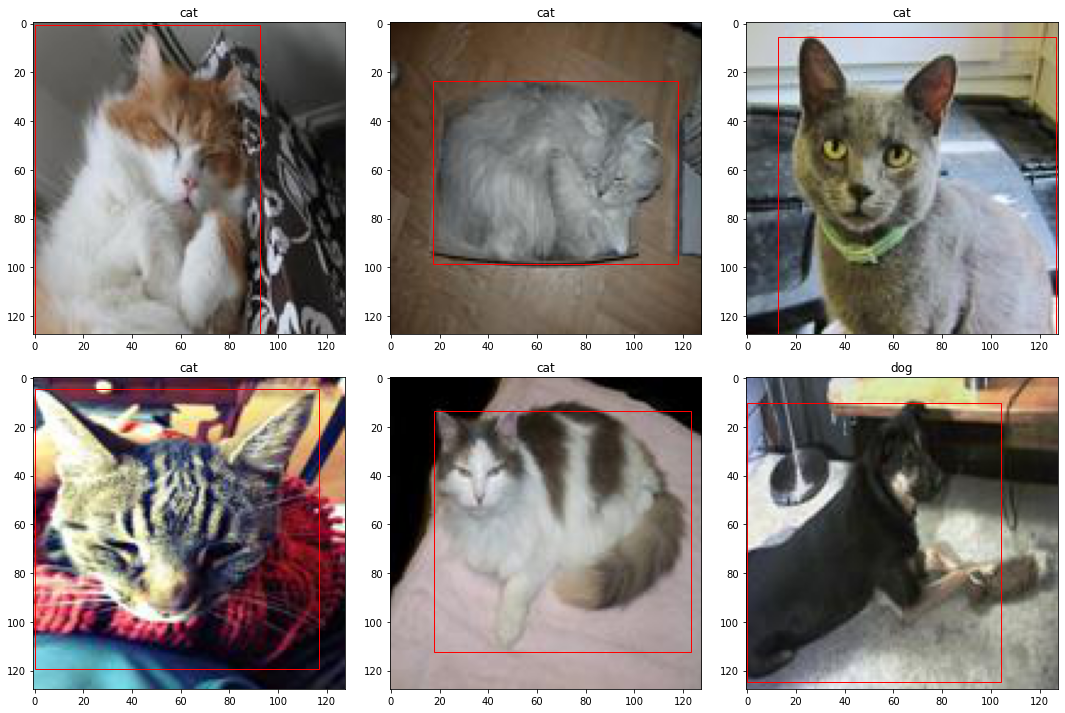

In [34]:
# Plot random 6 images
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(df.shape[0], size = 6, replace = False)):
    img = mpimg.imread(path + '/resized/' + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j, 4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j, 2])
    ax[i].add_patch(plt.Rectangle((coords[0] * w, coords[2] * h), 
                                  coords[1] * w - coords[0] * w, coords[3] * h - coords[2] * h, 
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

While the images are now lower quality, they are all the same shape (128 by 128 pixels) and it is still recognizable whether the image contains a dog or a cat.

Finally, let's create a new column in the metadata dataframe that encodes the label 'dog' as a 1 and encodes the label 'cat' as a 0. These new labels will be used in the machine learning algorithms.

In [35]:
# Encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)
df['Label']

0        1
1        1
2        1
3        1
4        1
        ..
12961    0
12962    0
12963    0
12964    0
12965    0
Name: Label, Length: 12966, dtype: uint8

## Checkpoint and Saving the Data

Now that exploratory data analysis and preprocessing steps are completed, let's save the image numpy array, the labels, and the normalized bounding box coordinates so that they can be loaded as needed later.

In [36]:
saved_data_exists = os.path.isdir('data/saved_data')
if saved_data_exists: print('The data/saved_data directory already exists.')

The data/saved_data directory already exists.


In [37]:
!mkdir -p data/saved_data

In [38]:
if not saved_data_exists:
    np.save('data/saved_data/img.npy', img_arr.astype(np.uint8))
    np.save('data/saved_data/y_label.npy', df.Label.values)
    np.save('data/saved_data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32))

# Baseline Models

Before creating more complex and sofisticated models, let's first create a baseline classification model and a baseline regression model. These models will be used to compare models that are created in the future, and the hope is to see major improvements the ability of the models to correctly classify the images as containing a cat or a dog and to correctly compute the bounding box coordinates of the object of interest.

## Load the Data

The data saved earlier is now reloaded into the corresponding variables `X`, `y_label`, and `y_bbox`.

In [39]:
X = np.load('data/saved_data/img.npy', allow_pickle = True)
y_label = np.load('data/saved_data/y_label.npy', allow_pickle = True)
y_bbox = np.load('data/saved_data/y_bbox.npy', allow_pickle = True)

## Check the Loaded Data

We first check to make sure that the data was properly loaded. Each of the variables should have 12966 rows (that is, one row for each image).

In [40]:
print(X.shape, y_label.shape, y_bbox.shape)

(12966, 49152) (12966,) (12966, 4)


In [41]:
X

array([[ 55, 129, 179, ...,  59, 140, 203],
       [121, 121, 119, ..., 254, 255, 255],
       [ 95, 101,  91, ...,  36,  25,  21],
       ...,
       [235, 235, 233, ..., 235, 232, 229],
       [209, 119,  10, ...,  32,   7,   2],
       [ 81,  67,  57, ..., 203, 195, 172]], dtype=uint8)

In [42]:
y_label

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [43]:
y_bbox

array([[0.165   , 0.268333, 0.90375 , 0.998333],
       [0.      , 0.      , 0.651875, 0.999062],
       [0.094167, 0.055626, 0.611667, 0.998736],
       ...,
       [0.001475, 0.042406, 0.988201, 0.62426 ],
       [0.      , 0.037523, 0.998125, 0.999062],
       [0.148045, 0.07064 , 0.999069, 0.94702 ]], dtype=float32)

## Plot Random Images

The following dictionary defines what the values of 1 and 0 refer to in the `y_label` array.

In [44]:
idx_to_label = {1:'dog', 0:'cat'} # For y_label, 1 refers to dog and 0 refers to cat

The code below plots some random images to ensure that all the data was properly loaded. Notice that here we are reconstructing the image from the numpy array itself instead of just showing the image that is saved in the `data/resized` directory. Thus, this code also checks that the images were properly flattened and converted to the numpy arrays.

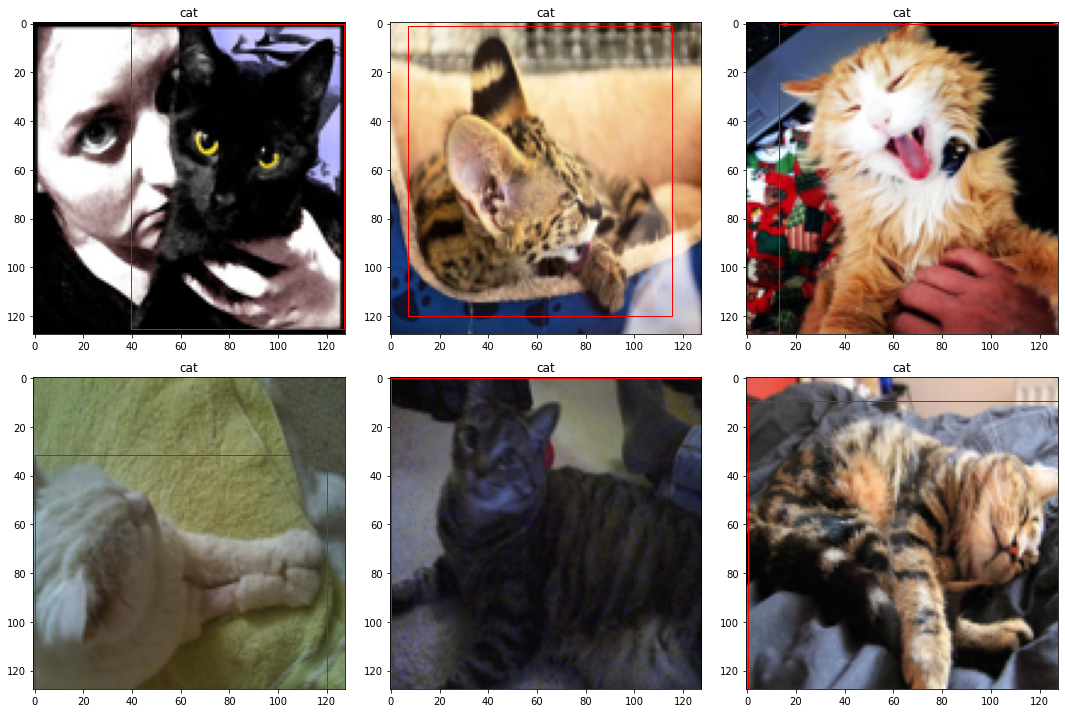

In [45]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, sharex = False, sharey = False, figsize = (15, 10))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X.shape[0], size = 6, replace = False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128, 128, 3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2] - coords[0], coords[3] - coords[1], 
                                  edgecolor = 'red', facecolor = 'none'))

plt.tight_layout()
plt.show()

Everything looks good so far in terms of loading the data!

## Classification Baseline: Logistic Regression (25% Subsample)

First we will create a classification baseline model using Logistic Regression. Only 25% of the samples are used in order to test the Logistic Regression model and ensure that it was properly performed.

In [46]:
# Set the random seed to 42 to ensure consist results for multiple runs of the program
np.random.seed(42)

# Split the data into train and test sets (80% train, 20% test)
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y_label, test_size = 0.2, random_state = 42)

# Set the subsample rate to 0.25
subsample_rate = 0.25

# Subsample the train and test sets to use only 25% of the samples
X_train_label_s, _, y_train_label_s, _ = train_test_split(X_train_label, y_train_label, stratify = y_train_label, train_size = subsample_rate, random_state = 42)
X_test_label_s, _, y_test_label_s, _ = train_test_split(X_test_label, y_test_label, stratify = y_test_label, train_size = subsample_rate, random_state = 42)

Let's check the sizes of all the variables defined above in order to make sure that the train and test splits and the subsample splits were performed properly.

In [47]:
print('X_train_label:', X_train_label.shape)
print('X_test_label:', X_test_label.shape)
print('y_train_label:', y_train_label.shape)
print('y_test_label:', y_test_label.shape)
print('X_train_label_s:', X_train_label_s.shape)
print('X_test_label_s:', X_test_label_s.shape)
print('y_train_label_s:', y_train_label_s.shape)
print('y_test_label_s:', y_test_label_s.shape)

X_train_label: (10372, 49152)
X_test_label: (2594, 49152)
y_train_label: (10372,)
y_test_label: (2594,)
X_train_label_s: (2593, 49152)
X_test_label_s: (648, 49152)
y_train_label_s: (2593,)
y_test_label_s: (648,)


The `model_results_label` dataframe below will store the results of the models that we create. This log will allow us to easily compare how different models perform.

In [48]:
model_results_label = pd.DataFrame(columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Train F1-Score', 'Test F1-Score'])
model_results_label

Empty DataFrame
Columns: [Model, Train Accuracy, Test Accuracy, Train F1-Score, Test F1-Score]
Index: []

Now we create a pipeline using the `Pipeline` class. First, we will scale the data using `MinMaxScaler()` so that all the values are squashed to be between 0 and 1. The Logistic Regression model is the next step of the pipeline, and we initialize it with an `l2` penalty and using the `lbfgs` solver. The maximum number of iterations is set to 15. The results of the model are calculated using the accuracy score, which measures how many labels the model got correct. The F1-Score is also calculated, and this represents the harmonic mean between the precision and recall scores. Higher values are better for both measures.

In [49]:
%%time
model = Pipeline([('scaler', MinMaxScaler()),
                  ('logreg', LogisticRegression(penalty = 'l2',
                                                solver = 'lbfgs',
                                                random_state = 42,
                                                max_iter = 15,
                                                n_jobs = -1,
                                                verbose = 5))], verbose = True)

model.fit(X_train_label_s, y_train_label_s)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   2.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.0min finished


[Pipeline] ............ (step 2 of 2) Processing logreg, total= 3.0min
CPU times: user 1.83 s, sys: 6.53 s, total: 8.36 s
Wall time: 3min 5s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg',
                 LogisticRegression(max_iter=15, n_jobs=-1, random_state=42,
                                    verbose=5))],
         verbose=True)

In [50]:
model_results_label.loc[len(model_results_label.index)] = ['Logistic Regression Baseline (25% Subsample)',
                                                           accuracy_score(y_train_label_s, model.predict(X_train_label_s)),
                                                           accuracy_score(y_test_label_s, model.predict(X_test_label_s)),
                                                           f1_score(y_train_label_s, model.predict(X_train_label_s)),
                                                           f1_score(y_test_label_s, model.predict(X_test_label_s))]

In [51]:
model_results_label

Model  Train Accuracy  \
0  Logistic Regression Baseline (25% Subsample)         0.66101   

   Test Accuracy  Train F1-Score  Test F1-Score  
0       0.537037        0.701528       0.590164

The code below plots 10 random images from the test image data, and allows us to visually see some of the results of the model. The probability of the label calculated by Logistic Regression is shown along with the label itself.

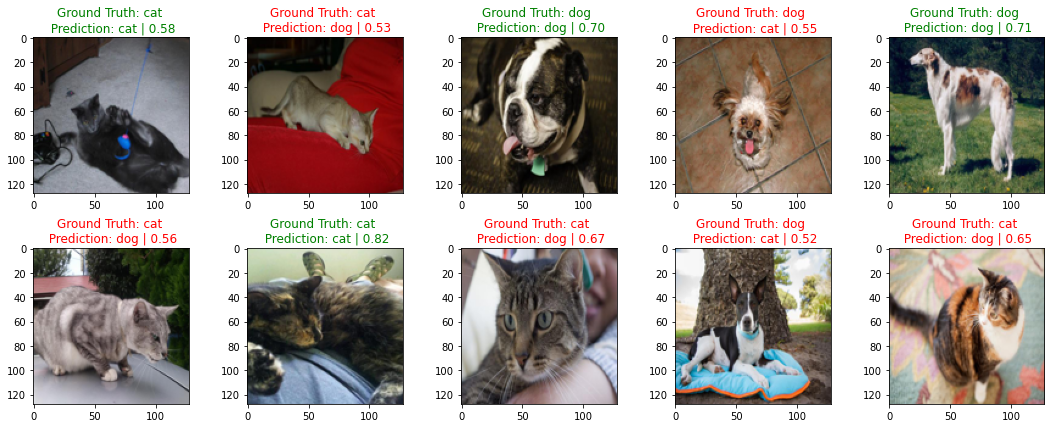

In [52]:
y_pred_label_s = model.predict(X_test_label_s)
y_pred_label_s_proba = model.predict_proba(X_test_label_s)

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = False, sharey = False, figsize = (15, 6))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X_test_label_s.shape[0], size = 10, replace = False)):
#for i in range(10):
    img = X_test_label_s[j].reshape(128, 128, 3)
    ax[i].imshow(img)
    ax[i].set_title('Ground Truth: {0} \n Prediction: {1} | {2:.2f}'.format(idx_to_label[y_test_label_s[j]], 
                                                                            idx_to_label[y_pred_label_s[j]],
                                                                            y_pred_label_s_proba[j][y_pred_label_s[j]]), 
                    color = ('green' if y_pred_label_s[j] == y_test_label_s[j] else 'red'))

plt.tight_layout()
plt.show()

### Results and Discussion
[insert here]

## Regression Baseline: Linear Regression (25% Subsample)

Next we will create a regression baseline model using Linear Regression. Only 25% of the samples are used in order to test the Linear Regression model and ensure that it was properly performed.

In [53]:
# Set the random seed to 42 to ensure consist results for multiple runs of the program
np.random.seed(42)

# Split the data into train and test sets (80% train, 20% test)
X_train_bbox, X_test_bbox, y_train_bbox, y_test_bbox = train_test_split(X, y_bbox, test_size = 0.2, random_state = 42)

# Set the subsample rate to 0.25
subsample_rate = 0.25

# Subsample the train and test sets to use only 25% of the samples
# We must stratify in the same way as with labels in order to merge the classification and regression results
X_train_bbox_s, _, y_train_bbox_s, _ = train_test_split(X_train_bbox, y_train_bbox, stratify = y_train_label, train_size = subsample_rate, random_state = 42)
X_test_bbox_s, _, y_test_bbox_s, _ = train_test_split(X_test_bbox, y_test_bbox, stratify = y_test_label, train_size = subsample_rate, random_state = 42)

Let's check the sizes of all the variables defined above in order to make sure that the train and test splits and the subsample splits were performed properly.

In [54]:
print('X_train_bbox:', X_train_bbox.shape)
print('X_test_bbox:', X_test_bbox.shape)
print('y_train_bbox:', y_train_bbox.shape)
print('y_test_bbox:', y_test_bbox.shape)
print('X_train_bbox_s:', X_train_bbox_s.shape)
print('X_test_bbox_s:', X_test_bbox_s.shape)
print('y_train_bbox_s:', y_train_bbox_s.shape)
print('y_test_bbox_s:', y_test_bbox_s.shape)

X_train_bbox: (10372, 49152)
X_test_bbox: (2594, 49152)
y_train_bbox: (10372, 4)
y_test_bbox: (2594, 4)
X_train_bbox_s: (2593, 49152)
X_test_bbox_s: (648, 49152)
y_train_bbox_s: (2593, 4)
y_test_bbox_s: (648, 4)


The `model_results_bbox` dataframe below will store the results of the models that we create. This log will allow us to easily compare how different models perform.

In [55]:
model_results_bbox = pd.DataFrame(columns = ['Model', 'Train MSE', 'Test MSE'])
model_results_bbox

Empty DataFrame
Columns: [Model, Train MSE, Test MSE]
Index: []

Now we create a pipeline using the `Pipeline` class. First, we will scale the data using `MinMaxScaler()` so that all the values are squashed to be between 0 and 1. The Linear Regression model is the next step of the pipeline, and we initialize it using the default parameters (other than n_jobs set to -1). The results of the model are calculated using the mean squared error, which measures how different the predicted normalized bounding box coordinates are from the true values. Lower values are typically better for mean squared error.

In [56]:
%%time
model = Pipeline([('scaler', MinMaxScaler()),
                  ('linreg', LinearRegression(n_jobs = -1))], verbose = True)

model.fit(X_train_bbox_s, y_train_bbox_s)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.0s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  45.3s
CPU times: user 3min 32s, sys: 39.8 s, total: 4min 12s
Wall time: 46.9 s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('linreg', LinearRegression(n_jobs=-1))],
         verbose=True)

In [57]:
model_results_bbox.loc[len(model_results_bbox.index)] = ['Linear Regression Baseline (25% Subsample)',
                                                         mean_squared_error(y_train_bbox_s, model.predict(X_train_bbox_s)),
                                                         mean_squared_error(y_test_bbox_s, model.predict(X_test_bbox_s))]

In [58]:
model_results_bbox

Model     Train MSE  Test MSE
0  Linear Regression Baseline (25% Subsample)  2.968540e-29  0.020752

The code below plots the same 10 random images from the test image data as before, and allows us to visually see some of the results of the model. The results for the regression and the classification model are combined by simply using the results from before and adding the predicted and true bounding boxes directly to the images.

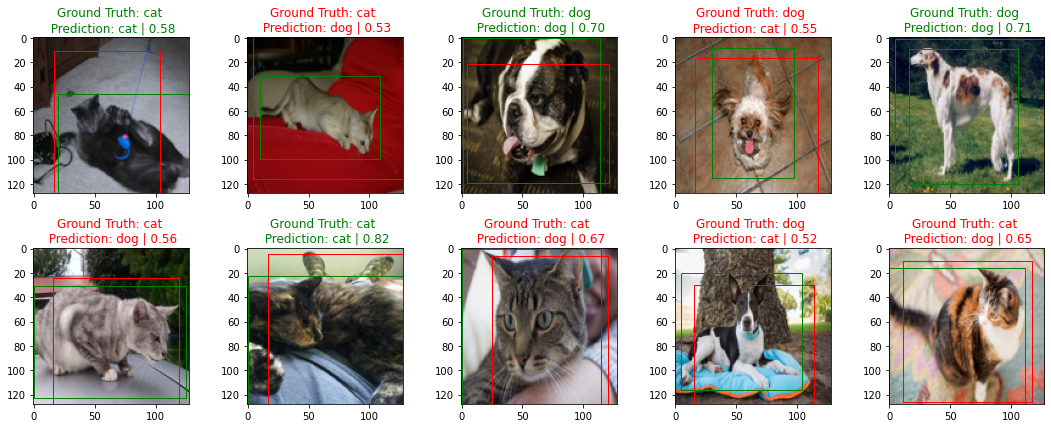

In [59]:
y_pred_bbox_s = model.predict(X_test_bbox_s)

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = False, sharey = False, figsize = (15, 6))
ax = ax.flatten()

for i, j in enumerate(np.random.choice(X_test_bbox_s.shape[0], size = 10, replace = False)):
#for j in range(10):
    img = X_test_bbox_s[j].reshape(128, 128, 3)
    coords = y_pred_bbox_s[j] * 128
    coords_true = y_test_bbox_s[j] * 128
    ax[i].imshow(img)
    ax[i].set_title('Ground Truth: {0} \n Prediction: {1} | {2:.2f}'.format(idx_to_label[y_test_label_s[j]],
                                                                            idx_to_label[y_pred_label_s[j]],
                                                                            y_pred_label_s_proba[j][y_pred_label_s[j]]),
                    color = ('green' if y_pred_label_s[j] == y_test_label_s[j] else 'red'))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]),
                                  coords[2] - coords[0], coords[3] - coords[1], 
                                  edgecolor = 'red', facecolor = 'none'))
    ax[i].add_patch(plt.Rectangle((coords_true[0], coords_true[1]),
                                  coords_true[2] - coords_true[0], coords_true[3] - coords_true[1], 
                                  edgecolor = 'green', facecolor = 'none'))

plt.tight_layout()
plt.show()

### Results and Discussion
[insert here]

## Classification and Regression Baseline Models Using 100% of the Data

Now let's see what happens when all of the data is used instead of the 25% subsample. The code below is largely the same as before, and the results using the full dataset are added to the model log dataframes respectively.

### Classification

In [60]:
%%time
model = Pipeline([('scaler', MinMaxScaler()),
                  ('logreg', LogisticRegression(penalty = 'l2',
                                                solver = 'lbfgs',
                                                random_state = 42,
                                                max_iter = 15,
                                                n_jobs = -1,
                                                verbose = 5))], verbose = True)

model.fit(X_train_label, y_train_label)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=  34.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 18.1min finished


[Pipeline] ............ (step 2 of 2) Processing logreg, total=18.2min


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg',
                 LogisticRegression(max_iter=15, n_jobs=-1, random_state=42,
                                    verbose=5))],
         verbose=True)

In [61]:
model_results_label.loc[len(model_results_label.index)] = ['Logistic Regression Baseline (All Data)',
                                                           accuracy_score(y_train_label, model.predict(X_train_label)),
                                                           accuracy_score(y_test_label, model.predict(X_test_label)),
                                                           f1_score(y_train_label, model.predict(X_train_label)),
                                                           f1_score(y_test_label, model.predict(X_test_label))]

In [62]:
model_results_label

Model  Train Accuracy  \
0  Logistic Regression Baseline (25% Subsample)        0.661010   
1       Logistic Regression Baseline (All Data)        0.602873   

   Test Accuracy  Train F1-Score  Test F1-Score  
0       0.537037        0.701528       0.590164  
1       0.558982        0.650250       0.609823

### Regression

In [1]:
%%time
model = Pipeline([('scaler', MinMaxScaler()),
                  ('linreg', LinearRegression(n_jobs = -1))], verbose = True)

model.fit(X_train_bbox, y_train_bbox)

NameError: name 'Pipeline' is not defined

In [ ]:
model_results_bbox.loc[len(model_results_bbox.index)] = ['Linear Regression Baseline (All Data)',
                                                         mean_squared_error(y_train_bbox, model.predict(X_train_bbox)),
                                                         mean_squared_error(y_test_bbox, model.predict(X_test_bbox))]

In [ ]:
model_results_bbox

### Results

# Sklearn CaDoD Pipeline and GridSearch

# Homegrown Logistic Regression

# Overall Results and Discussion

# Conclusion